# Tf-Idf + Stratification w.r.t. keyword and target

In [1]:
import pandas as pd
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import cross_validate, learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# BASE_DIR = Path('/home/giovenko/Projects/real_or_not')
HOME_DIR = Path.home()
BASE_DIR = Path(HOME_DIR/'Projects/real_or_not')
INPUT_DIR = BASE_DIR/'data/input'
OUTPUT_DIR = BASE_DIR/'data/output'

In [3]:
train_df = pd.read_csv(INPUT_DIR/'train.csv')
test_df = pd.read_csv(INPUT_DIR/'test.csv')

train_df['keyword'] = train_df.keyword.fillna('missing')
train_df['str_target'] = train_df.target.apply(lambda x: str(x))
train_df['keyword_target'] = train_df.keyword.str.cat(train_df.str_target)

test_df['keyword'] = test_df.keyword.fillna('missing')

In [4]:
pipe = Pipeline([
    ('cvec', TfidfVectorizer(stop_words='english')),
    # ('cvec', CountVectorizer(stop_words='english')),
    #('clf', RidgeClassifier())
    ('clf', LogisticRegression())
])

In [5]:
# Cross validation scheme stratified by keyword
skf = StratifiedKFold(n_splits=5) #, shuffle=True, random_state=42)
cv = skf.split(train_df, train_df.keyword_target)

## `cross_validate`

In [6]:
from sklearn.base import clone
model = clone(pipe)
scores = cross_validate(model, train_df['text'], train_df['target'], scoring='f1', cv=cv, return_train_score=True)
# scores = cross_val_score(pipe, train_df['text'], train_df['target'], scoring='f1', cv=cv)
# print('score: {:.3f} +/- {:.3f}'.format(scores.mean(), 2*scores.std()))

/home/giovenko/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [7]:
print(pd.DataFrame(scores))

   fit_time  score_time  test_score  train_score
0  0.363833    0.037083    0.748079     0.864208
1  0.258825    0.036626    0.746929     0.859445
2  0.282267    0.037286    0.745161     0.858955
3  0.229987    0.037290    0.752743     0.862455
4  0.280228    0.037295    0.732787     0.864343


## `learning_curves`

In [8]:
model = clone(pipe)
cv = skf.split(train_df, train_df.keyword_target)
lc = learning_curve(model, train_df.text, train_df.target, cv=cv, scoring='f1', random_state=42)

/home/giovenko/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [9]:
lc

(array([ 609, 1979, 3349, 4719, 6090]),
 array([[0.75070028, 0.76584022, 0.75862069, 0.76595745, 0.752     ],
        [0.84388807, 0.84171598, 0.83961567, 0.84023669, 0.83258595],
        [0.86722156, 0.86741214, 0.86611045, 0.86523126, 0.86804452],
        [0.8649685 , 0.86079467, 0.85674625, 0.86717892, 0.86243094],
        [0.86420788, 0.85944456, 0.85895538, 0.86239696, 0.86428571]]),
 array([[0.25680934, 0.25725095, 0.2549505 , 0.25699746, 0.26566416],
        [0.55842813, 0.56517413, 0.54905847, 0.5595117 , 0.56673511],
        [0.68592058, 0.69012876, 0.69394714, 0.71210762, 0.70497427],
        [0.73367698, 0.73873874, 0.74104235, 0.73452078, 0.73044925],
        [0.74807857, 0.74692875, 0.74516129, 0.75274262, 0.73278689]]))

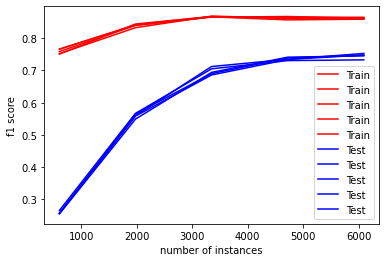

In [10]:
import matplotlib.pyplot as plt
plt.plot(lc[0], lc[1], '-r', label='Train')
plt.plot(lc[0], lc[2], '-b', label='Test')
plt.xlabel('number of instances')
plt.ylabel('f1 score')
plt.legend()

## Understanding overfitting

We have many more features than we have observations.

In [11]:
model.fit(train_df['text'], train_df['target'])
print('N. features: {}\nN. instances: {}'.format(len(model['cvec'].vocabulary_),
                                                  train_df.shape[0]))

N. features: 21363
N. instances: 7613


However, neither selecting the top 1000, 5000, 10000 Tf-Idf features, nor increasing the value of `alpha` has a beneficial effect, in the sense that both the training and the validation performances degrade.

One surprising thing is that the optimal `alpha` value is 1, i.e. the default value. This is a strange coincidence.

In [13]:
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100]
}
model = clone(pipe)
cv = skf.split(train_df, train_df.keyword_target)
gscv = GridSearchCV(model, param_grid, scoring='f1', cv=cv)
gscv.fit(train_df.text, train_df.target)

/home/giovenko/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/home/giovenko/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/giovenko/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Incre

GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f08f5eb33c0>,
             estimator=Pipeline(steps=[('cvec',
                                        TfidfVectorizer(stop_words='english')),
                                       ('clf', LogisticRegression())]),
             param_grid={'clf__C': [0.01, 0.1, 1, 10, 100]}, scoring='f1')

In [14]:
gscv.best_params_

{'clf__C': 10}

In [15]:
gscv.best_score_

0.7479327987567058

In [12]:
# sample_submission = pd.read_csv(INPUT_DIR/'sample_submission.csv')
# sample_submission['target'] = y_pred
# sample_submission.to_csv(OUTPUT_DIR/'submission_tfidf_keyword_target.csv', index=False)